# Download Required Packages

In [1]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

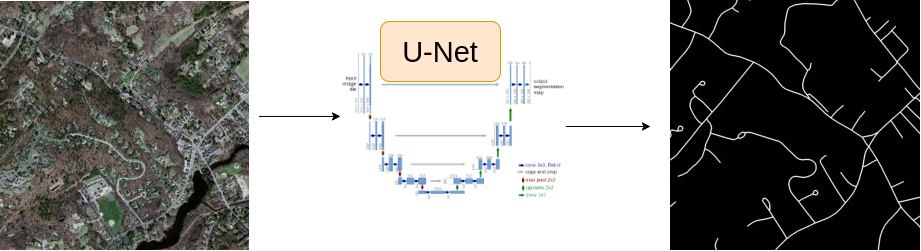

# Download Dataset Subset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


In [3]:
#Helper Plot Function

def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import albumentations as A 
import cv2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = "/content/Road_seg_dataset/train.csv"
DATA_DIR = "/content/Road_seg_dataset/"
device = "cuda"
epoch = 30
lr = 0.003
BATCH_SIZE = 8
IMAGE_SIZE = 512
ENCODER = "timm-efficientnet-b2"
WEIGHTS = "imagenet"


In [7]:
#Read Data File
df = pd.read_csv(CSV_FILE)
print(df.shape)
df.head()

(199, 2)


,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
#Check and Plot A sample Image with its corresponding Mask
idx = 2
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0


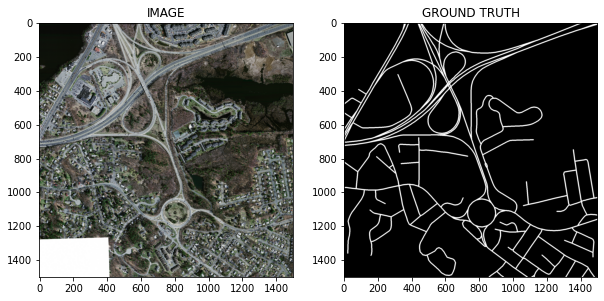

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
#Split Data into train and Validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((159, 2), (40, 2))

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
def get_train_augs():

  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(0.5),
                    A.VerticalFlip(0.5)
      
  ],is_check_shapes=False)

def get_valid_augs():

  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [12]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):

    return len(self.df)

  def __getitem__(self, idx):
    
    row = self.df.iloc[idx]
    
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = np.expand_dims(mask,axis=-1) #Expand Mask Dimension to compensate for Absent Color Channel in Mask


    if self.augmentations:
      
      data = self.augmentations(image=image, mask=mask)

      image = data['image'] #shape = (h,w,c)
      mask = data['mask'] #shape = (h,w,c)

      #Convert Image and Mask into Pytorch Standard shape format, i.e (h,w,c) --> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    #Convert from Numpy array to Torch Tensors and scale values to between 0 and 1 i.e divide by 255.0

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)



    return image, mask



In [13]:
#Get Train and Valid set from Custom dataset
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [14]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 159
Size of Validset : 40


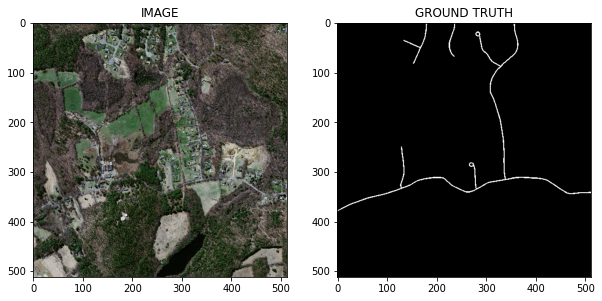

In [15]:
#Plot Sample Image and Mask
idx = 3
image, mask = trainset[idx]
show_image(image,mask)

# Task 5 : Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, BATCH_SIZE)

In [17]:
print(f"Size of TrainLoader : {len(trainloader)}")
print(f"Size of ValidLoader : {len(validloader)}")

Size of TrainLoader : 20
Size of ValidLoader : 5


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [18]:
class SMP(nn.Module):
  def __init__(self) -> None:
    super(SMP,self).__init__()
    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels = 3,
        classes= 1,
        activation = None,
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if mask != None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      loss = loss1+loss2

      return logits, loss

    return logits




In [19]:
#Intialize and Download Model Weights
model = SMP()
model.to(device);

# Task 7 : Create Train and Validation Function 

In [20]:

def train_fn(model,data_loader,optimizer):

  #Set Model to Train mode
  model.train()
  total_loss = 0.0

  #training loop
  for image,mask in tqdm(data_loader):
    #Pass Image and Mask to device, same as model
    image = image.to(device)
    mask = mask.to(device)

    #Zero Grad to avoid gradient accumulation

    optimizer.zero_grad()

    #Train model
    logit,loss = model(image,mask)
    
    #Calculate grad
    loss.backward()

    #Update Weights

    optimizer.step()

    #Calculate Loss
    total_loss+=loss.item()

  #Calculate Loss per Batch

  avg_loss = total_loss/len(data_loader)

  return avg_loss


In [21]:
def val_fn(model,data_loader):

  #Set Model to Train mode
  model.eval()
  total_loss = 0.0

  #Evaluation loop

  #No Gradient Calculation or weight update(backprop) step required

  with torch.no_grad():

    for image, mask in tqdm(data_loader):
      
      image, mask = image.to(device), mask.to(device)
      logit, loss = model(image, mask)

      total_loss+= loss.item()

  avg_loss = total_loss/len(data_loader)

  return avg_loss


# Task 8 : Train Model

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [23]:
#Initialize best Valid Loss to a large number
best_valid_loss = np.Infinity

for i in range(epoch):
  train_loss = train_fn(model,trainloader, optimizer)
  valid_loss = val_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-model.pt') #Save Best Model Weights for Inference
    print("Model Saved")

    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss is : {train_loss}, Valid Loss is : {valid_loss}" )

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Model Saved
Epoch: 1 Train Loss is : 0.9499983012676239, Valid Loss is : 1.1183578968048096


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 2 Train Loss is : 0.6632426768541336, Valid Loss is : 1.1353431224822998


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Model Saved
Epoch: 3 Train Loss is : 0.6167468577623367, Valid Loss is : 0.8717886686325074


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 4 Train Loss is : 0.5701080784201622, Valid Loss is : 0.9027104258537293


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 5 Train Loss is : 0.5539670899510384, Valid Loss is : 0.9059292078018188


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch: 6 Train Loss is : 0.5336819469928742, Valid Loss is : 0.8847960114479065


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Model Saved
Epoch: 7 Train Loss is : 0.5267722949385643, Valid Loss is : 0.8648097157478333


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 8 Train Loss is : 0.4990374058485031, Valid Loss is : 0.9076215505599976


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch: 9 Train Loss is : 0.4982156068086624, Valid Loss is : 0.8758383154869079


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Model Saved
Epoch: 10 Train Loss is : 0.48827351480722425, Valid Loss is : 0.8393251895904541


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 11 Train Loss is : 0.489451901614666, Valid Loss is : 0.8873879075050354


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch: 12 Train Loss is : 0.4834729880094528, Valid Loss is : 0.8765568137168884


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch: 13 Train Loss is : 0.47165288478136064, Valid Loss is : 0.8790182590484619


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 14 Train Loss is : 0.46240459084510804, Valid Loss is : 0.9156461358070374


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 15 Train Loss is : 0.4494416207075119, Valid Loss is : 0.8478503227233887


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch: 16 Train Loss is : 0.452813608944416, Valid Loss is : 0.8527281641960144


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 17 Train Loss is : 0.4443927049636841, Valid Loss is : 0.8980407953262329


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Model Saved
Epoch: 18 Train Loss is : 0.43787476420402527, Valid Loss is : 0.8390337705612183


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch: 19 Train Loss is : 0.4326357290148735, Valid Loss is : 0.8743170261383056


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 20 Train Loss is : 0.4253388300538063, Valid Loss is : 0.8821769475936889


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 21 Train Loss is : 0.4160239636898041, Valid Loss is : 0.911296832561493


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch: 22 Train Loss is : 0.41564289331436155, Valid Loss is : 0.8473161220550537


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch: 23 Train Loss is : 0.40618976652622224, Valid Loss is : 0.8673462748527527


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 24 Train Loss is : 0.41979830265045165, Valid Loss is : 0.874345338344574


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 25 Train Loss is : 0.42289803326129916, Valid Loss is : 0.9456182360649109


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch: 26 Train Loss is : 0.4097911462187767, Valid Loss is : 0.8996694803237915


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 27 Train Loss is : 0.3975491404533386, Valid Loss is : 0.875123941898346


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Epoch: 28 Train Loss is : 0.3953355669975281, Valid Loss is : 0.8999860286712646


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch: 29 Train Loss is : 0.38278535306453704, Valid Loss is : 0.8797226071357727


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

Epoch: 30 Train Loss is : 0.38014430105686187, Valid Loss is : 0.934337031841278


# Task 9 : Inference

In [24]:
idx = 13

model.load_state_dict(torch.load("/content/best-model.pt"))

image, mask = validset[idx]
model.to(device)

model.eval()
logits_mask = model(image.to(device).unsqueeze(0), mask.to(device).unsqueeze(0)) #Unsqueezing to switch dim from c-h-w to b-c-h-w,b=batch

pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5) * 1.0

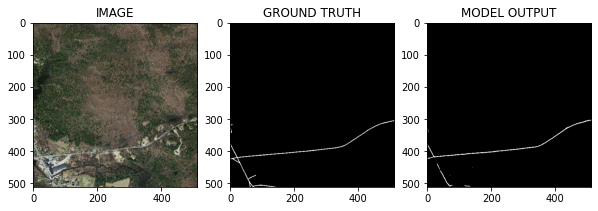

In [25]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))